# Velocity

In [116]:
%load_ext autoreload
%autoreload 2
import json

import matplotlib.pyplot as plt
import numpy as np
from pydantic import Field
from pydantic.dataclasses import dataclass
from sympy import pi, cos, sin, maximum, lambdify, Interval, minimum, diff, solve
from sympy.core.symbol import Symbol

from binaryStatistics.base_distribution import BaseDistribution
from binaryStatistics.distributions import Uniform, Thermal, PowerLaw
from binaryStatistics.plot_utils import plot_histogram

data_length = 100_000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$$
\tilde{v}\left( \phi, \phi_0, i, e \right) = \sqrt[4]{1 - \sin^2 i \cos^2 \left( \phi - \phi_0 \right)} \sqrt{\frac{1 + e^2 + 2e\cos\phi - \sin^2 i \left( e\sin\phi_0 - \sin \left( \phi - \phi_0 \right) \right)}{1 - e\cos\phi}}
$$

## Eccentricity $e$

Thermal distribution

$$
p(e) = 2e
$$

In [151]:
rand = np.random.uniform(0,1,size=data_length)
thermal = Thermal()
e = thermal.random_sample(0,1,size=data_length)
e = np.sqrt(rand)

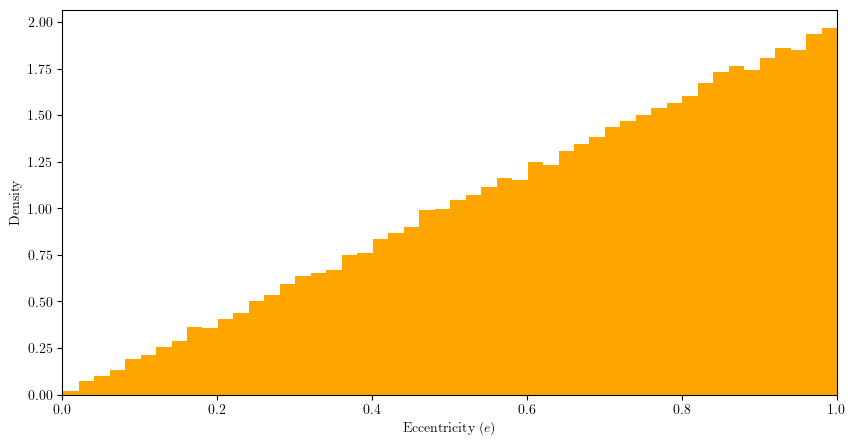

In [152]:
_ = plot_histogram(
    e,
    bins=50,
    density=True,
    color="#ffa500",
    x_params={
        "label": "Eccentricity ($e$)",
        "limits": (0,1),
    },
    file="distributions_files/eccentricity.png"
)

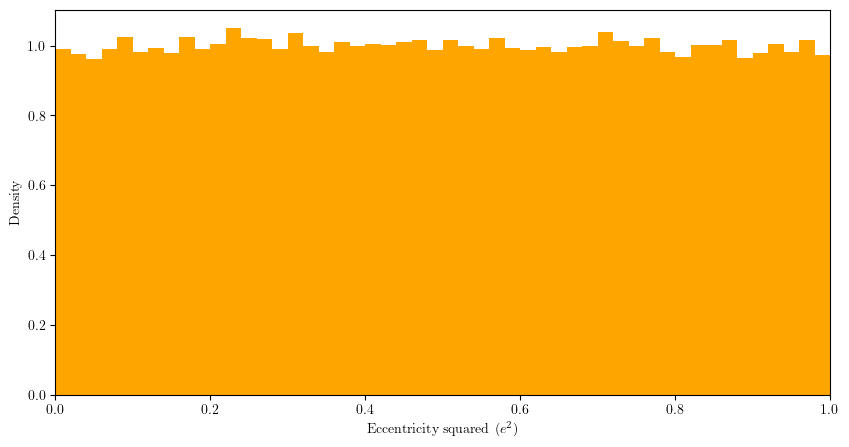

In [153]:
_ = plot_histogram(
    e**2,
    bins=50,
    density=True,
    color="#ffa500",
    x_params={
        "label": "Eccentricity squared ($e^2$)",
        "limits": (0,1),
    },
    file="distributions_files/eccentricity_squared.png"
)

## Orbit angle $i$

$$
p(i) = \sin(i)
$$

In [154]:
@dataclass
class Sine(BaseDistribution):
    
    dist_parameters: dict = Field(default={})
    
    def __post_init_post_parse__(self):
        super().__init__(self.dist_parameters)
        
    def distribution(self, i):
        return np.sin(i)

In [155]:
sine = Sine()
i = sine.random_sample(0,np.pi/2,size=data_length)
i = np.arccos(rand)

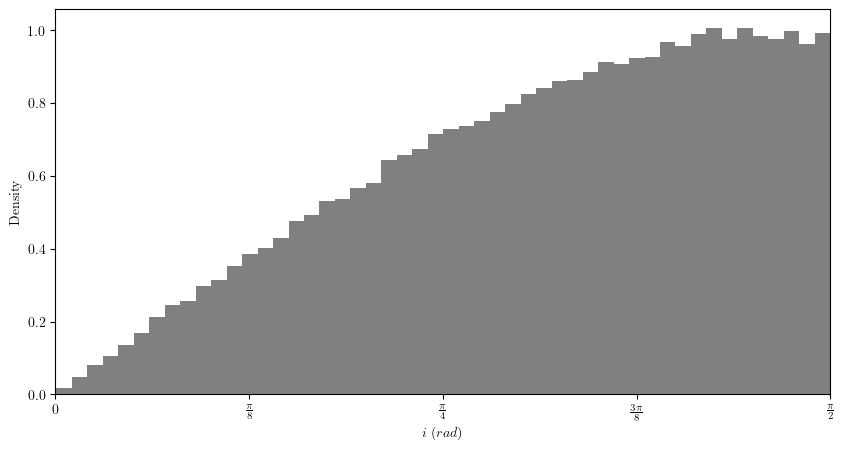

In [156]:
_ = plot_histogram(
    i,
    bins=50,
    density=True,
    color="gray",
    x_params={
        "label": "$i$ ($rad$)",
        "limits": (0, np.pi/2)
    },
    pi_factor=8,
    file="distributions_files/orbit_angle.png"
)

## Phase angle $\phi$

$$
p\left( \phi | e \right) = \frac{\left( 1 - e^2\right)^{3/2}}{2\pi \left( 1 + e \cos\phi \right)^2},
$$

In [289]:
from functools import partial
import random
@dataclass
class PhiAngle(BaseDistribution):
    
    dist_parameters: dict = Field(default={})
    
    def __post_init_post_parse__(self):
        super().__init__(self.dist_parameters)
        self.phi = Symbol("phi")
        self.e = Symbol("e")
        
        
    def distribution(self, phi, e):
        if isinstance(phi, Symbol):
            return ((1.0 - e**2.0)**(3.0/2.0))/(2*pi*(1 + e*cos(phi))**2)
        return ((1.0 - e**2.0)**(3.0/2.0))/(2*np.pi*(1 + e*np.cos(phi))**2)
    
    def get_pdf_derivative_phi(self):
        self.pdf = phi_angle.distribution(self.phi,self.e)
        return diff(self.pdf, self.phi)

    def get_pdf_maximum_func(self):
        dpdf = self.get_pdf_derivative_phi()
        roots = solve(dpdf, self.phi)
        
        max_root = 0
        max_index = 0
        e = random.choice(self.dist_parameters["e"])
        for index, root in enumerate(roots):
            current_root = lambdify(self.e, lambdify(self.phi,self.pdf)(float(root)))(e)
            if current_root > max_root:
                max_index = index
                max_root = current_root
                
        return lambdify(self.phi, self.pdf)(float(roots[max_index]))

In [295]:
phi_4 = []
ecc = Symbol("e")
f = phi_angle.get_pdf_maximum_func()
for index in range(data_length):
    LI = 0
    while LI < 1:
        E = e[index]
        c = (1 - E**2)/(2*np.pi*(1 - E)**2)
        c = lambdify(ecc, f)(E)
        base = 2*np.pi
        Phi = np.random.uniform()*base
        pPhi = np.random.uniform()*c 
        if pPhi <= phi_angle.distribution(Phi,E):
            LI = 2
            phi_4.append(Phi)

KeyboardInterrupt: 

In [294]:
len(phi_4)

750

In [291]:
x = Symbol("x")

In [292]:
phi_angle = PhiAngle(
    dist_parameters = {
        "e": e
    }
)

In [285]:
phi_angle.get_pdf_maximum_func()

TypeError: PhiAngle.get_pdf_maximum_func() missing 1 required positional argument: 'e'

In [284]:
lambdify(phi_angle.get_pdf_maximum_func())(0.3)

TypeError: PhiAngle.get_pdf_maximum_func() missing 1 required positional argument: 'e'

In [267]:
lambdify(ecc,f)(0.3)

0.28195911587004907

In [207]:
x = Symbol("x")
ecc = Symbol("e")

In [208]:
f = phi_angle.distribution(x,e=ecc)

In [209]:
df = diff(f,x)

In [210]:
df

e*(1.0 - e**2.0)**1.5*sin(x)/(pi*(e*cos(x) + 1)**3)

In [212]:
lambdify(ecc, lambdify(x,f)(0))(0.3)

0.08175145963096095

In [213]:
lambdify(ecc, lambdify(x,f)(np.pi))(0.3)

0.28195911587004907

In [97]:
pdf = phi_angle.distribution(x, e=e[3])

In [101]:
pdf

0.237868405734947/(pi*(0.624970208522509*cos(x) + 1)**2)

In [33]:
phi_angle = PhiAngle(
    dist_parameters={
        "e": e,
    }
)
phi = phi_angle.random_sample(0.0,2*np.pi,size=data_length)

KeyboardInterrupt: 

In [13]:
phi_2 = []
for i in range(len(phi)):
    LI = 0
    while LI < 1:
        ecc = np.sqrt(np.random.uniform())
        PhiT = np.random.uniform(0,1)*2*np.pi
        RnT = np.random.uniform(0,1)
        PPhi = np.random.uniform(0,1)/(1.0 - e[i])**2
        temp = (1 + e[i]*np.cos(PhiT))**2
        if PPhi < (1.0/temp):
            LI = 2;
            Phi=PhiT
            phi_2.append(Phi)

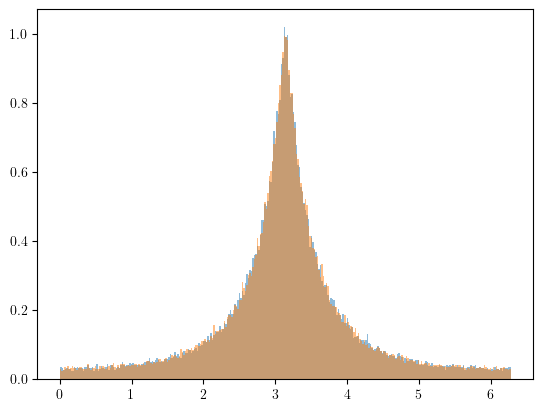

In [14]:
_=plt.hist(phi,bins=300, density=True, alpha=0.5)
_=plt.hist(phi_2,bins=300, density=True, alpha=0.5)

In [15]:
np.median(phi), np.median(phi_2)

(3.1439681931751036, 3.142955550280072)

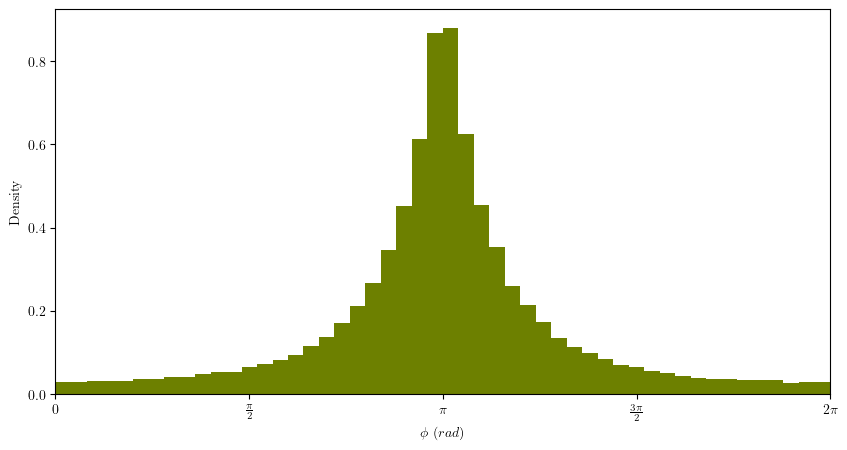

In [16]:
_ = plot_histogram(
    phi,
    bins=50,
    density=True,
    color="#6d8000",
    x_params={
        "label": "$\phi$ ($rad$)",
        "limits": (0,2*np.pi)
    },
    pi_factor=2,
    file="distributions_files/phase_angle.png"
)

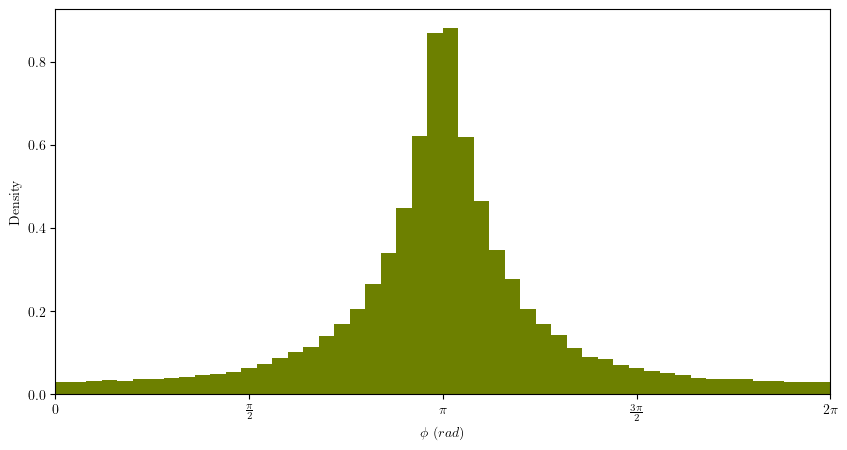

In [17]:
_ = plot_histogram(
    phi_2,
    bins=50,
    density=True,
    color="#6d8000",
    x_params={
        "label": "$\phi$ ($rad$)",
        "limits": (0,2*np.pi)
    },
    pi_factor=2,
    file="distributions_files/phase_angle.png"
)

## Initial phase angle $\phi_0$

$$
p \left(\phi_0\right) = \mathcal{U} \left\lbrace 0, 2\pi \right\rbrace
$$

In [18]:
uniform = Uniform()
phi_0 = uniform.random_sample(0,2*np.pi,size=data_length)
phi_0 = np.random.uniform(0,2*np.pi, size=data_length)

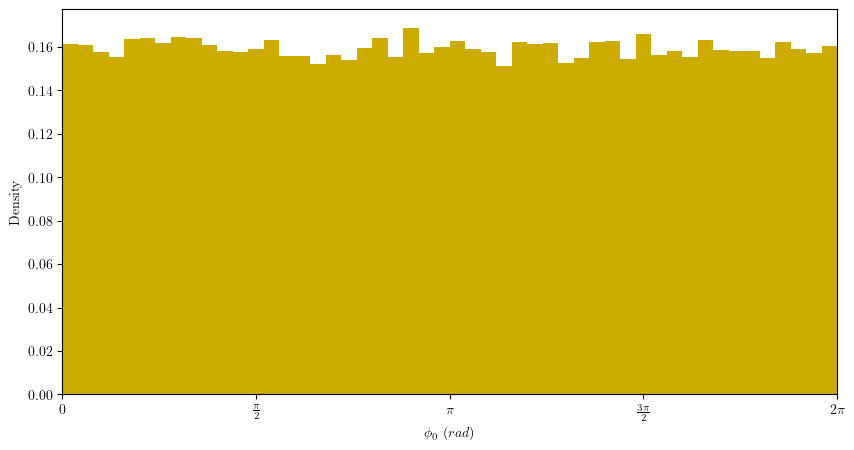

In [19]:
_ = plot_histogram(
    phi_0,
    bins=50,
    density=True,
    color="#ccac00",
    x_params={
        "label": "$\\phi_0$ ($rad$)",
        "limits": (0, 2*np.pi)
    },
    pi_factor=2,
    file="distributions_files/initial_phase_angle.png"
)

## Velocity $\tilde{v}$

In [20]:
@dataclass
class VelTilde(BaseDistribution):
    
    dist_parameters: dict = Field(default={})
    
    def __post_init_post_parse__(self):
        super().__init__(self.dist_parameters)
        
    def distribution(self, phi, phi_0, i, e):
        #term_1 = (1.0 + e**2 + 2*e*np.cos(phi))/(1 + e*np.cos(phi))
        #term_3 = 1.0 - (np.sin(i)**2)*(np.cos(alpha + phi - phi_0)**2)
        temp2 = 1.0 - (np.sin(i)**2)*(np.cos(phi - phi_0)**2)
        temp2 = temp2**0.25
        
        temp1 = e*np.sin(phi_0) - np.sin(phi-phi_0)
        temp1 = temp1*temp1
        
        temp3 = (1.0 + e*e + 2*e*np.cos(phi) - np.sin(i)*np.sin(i)*temp1)/(1.0 + e*np.cos(phi))
        temp3 = np.sqrt(temp3)
        
        return temp2*temp3

In [21]:
e = thermal.random_sample(0,1,size=data_length)
i = sine.random_sample(0,np.pi/2,size=data_length)
phi_0 = uniform.random_sample(0,2*np.pi,size=data_length)
phi_angle = PhiAngle(
    dist_parameters={
        "e":e
    }
)
phi = phi_angle.random_sample(0.0,2*np.pi,size=data_length)

In [23]:
phi_4 = []
for index in range(data_length):
    LI = 0
    while LI < 1:
        E = e[index]
        c = (1 - E**2)/(2*np.pi*(1 - E)**2)
        base = 2*np.pi
        Phi = np.random.uniform()*base
        pPhi = np.random.uniform()*c 
        if pPhi <= phi_angle.distribution(Phi,E):
            LI = 2
            phi_4.append(Phi)

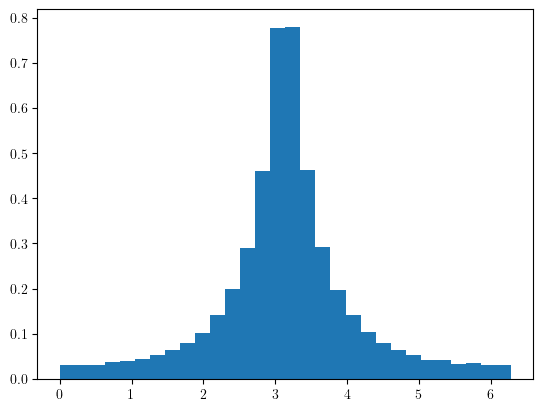

In [24]:
_=plt.hist(phi_4, bins=30, density=True)

In [25]:
# Rejection method
phi_2 = []
for index in range(len(phi)):
    LI = 0
    while LI < 1:
        PhiT = np.random.uniform(0,1)*2*np.pi
        RnT = np.random.uniform(0,1)
        PPhi = np.random.uniform(0,1)/(1.0 - e[index])**2
        temp = (1 + e[index]*np.cos(PhiT))**2
        if PPhi < (1.0/temp):
            LI = 2;
            Phi=PhiT
            phi_2.append(Phi)

In [26]:
vel = VelTilde()
v_tilde_1 = vel.distribution(
    phi_4, 
    phi_0,
    i,
    e
)
v_tilde_2 = vel.distribution(
    phi_2, 
    phi_0,
    i,
    e
)

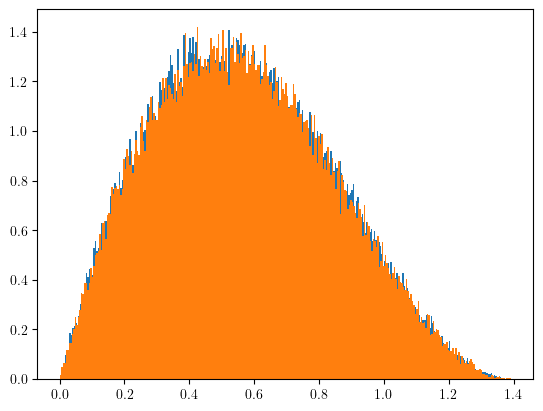

In [27]:
_=plt.hist(v_tilde_1, bins=300, density=True)
_=plt.hist(v_tilde_2, bins=300, density=True)

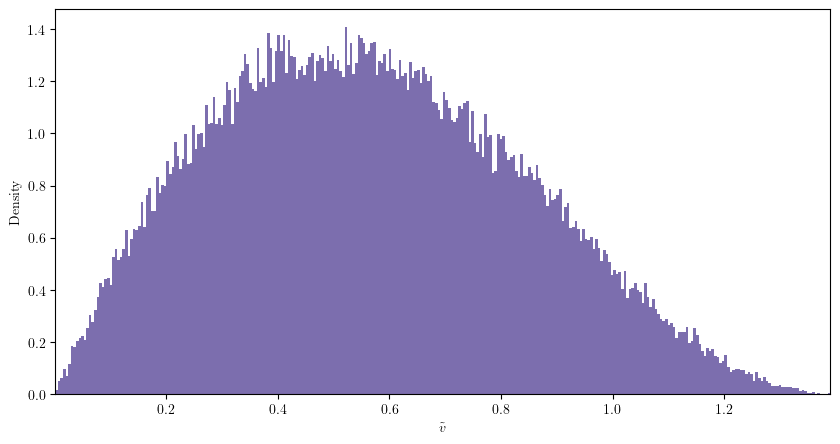

In [28]:
fig, ax = plot_histogram(
    v_tilde_1,
    bins=300,
    density=True,
    color="#7c6eae",
    x_params={
        "label":"$\\tilde{v}$",
    },
    file="distributions_files/v2d.png"
)

In [29]:
with open("../VTil.dat","r") as file:
    lines = file.readlines()
    
    v = []
    v_dist = []
    for line in lines:
        vel, dist = line.strip().split(" ")
        v.append(float(vel))
        v_dist.append(float(dist))

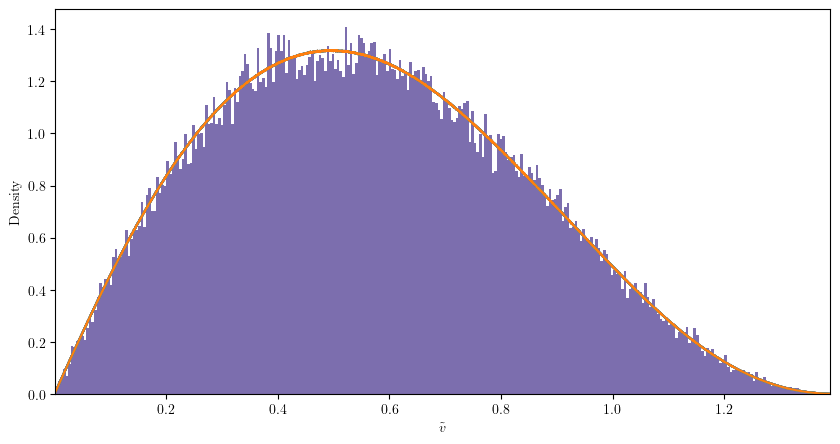

In [41]:
ax.plot(v, v_dist)
fig